### 导入包

In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

### PyG构建数据集

In [2]:
'''
生成Graph的节点数据集，使用Cora数据集，以及torch_geometric.data.Data方法，
需要参数如下：
    x : torch.Tensor, 节点特征矩阵，shape为[num_nodes, num_node_features]
    edge_index : LongTensor, Graph的连接矩阵，shape为[2, num_edges]
    edge_attr : None, 暂不需要
    y : Tensor, 图或节点的标签，shape任意
    pos : Tensor, 暂不需要
    norm : Tensor, 暂不需要
    face : LongTensor, 暂不需要
'''
content_path = "./cora/cora.content"
cite_path = "./cora/cora.cites"

# 读取文本内容
with open(content_path, "r") as fp:
    contents = fp.readlines()
with open(cite_path, "r") as fp:
    cites = fp.readlines()

# 边列表
cites = list(map(lambda x: x.strip().split("\t"), cites))

# 构建映射字典
paper_list, feat_list, label_list = [], [], []
for line in tqdm(contents):
    tag, *feat, label = line.strip().split("\t")
    paper_list.append(tag)
    feat_list.append(np.array(list(map(lambda x: int(x), feat))))
    label_list.append(label)
# Paper -> Index 字典
paper_dict = dict([(key, val) for val, key in enumerate(paper_list)])
# Label -> Index 字典
label_dict = dict([(key, val) for val, key in enumerate(set(label_list))])
# Edge_index构建
cites = np.array([[paper_dict[i[0]], paper_dict[i[1]]] for i in cites], 
                 np.int64).T                                 # (2, edge)
cites = np.concatenate((cites, cites[::-1, :]), axis=1)      # (2, 2*edge), 即(2, E)
# y 构建
y = np.array([label_dict[i] for i in label_list])
# Input 构建
x = torch.from_numpy(np.array(feat_list, dtype=np.float32))  # [N, Feat_Dim]
edge_index = torch.from_numpy(cites)                         # [E, 2]
y = torch.from_numpy(y)                               # [N, ]

# 构建Data类
data = Data(x=x,
            edge_index=edge_index,
            y=y)
# 分割数据集
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.uint8)
data.train_mask[:data.num_nodes - 1000] = 1                  # 1700左右training
data.val_mask = None                                         # 0valid
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.uint8)
data.test_mask[data.num_nodes - 500:] = 1                    # 500test
data.num_classes = len(label_dict)

100%|██████████| 2708/2708 [00:00<00:00, 2799.36it/s]


### 打印数据信息

In [3]:
data

Data(edge_index=[2, 10858], num_classes=[1], test_mask=[2708], train_mask=[2708], x=[2708, 1433], y=[2708])

In [4]:
print("{}Data Info{}".format("*"*20, "*"*20))
print("==> Is undirected graph : {}".format(data.is_undirected()))
print("==> Number of edges : {}/2={}".format(data.num_edges, int(data.num_edges/2)))
print("==> Number of nodes : {}".format(data.num_nodes))
print("==> Node feature dim : {}".format(data.num_node_features))
print("==> Number of training nodes : {}".format(data.train_mask.sum().item()))
print("==> Number of testing nodes : {}".format(data.test_mask.sum().item()))
print("==> Number of classes : {}".format(data.num_classes))

********************Data Info********************
==> Is undirected graph : True
==> Number of edges : 10858/2=5429
==> Number of nodes : 2708
==> Node feature dim : 1433
==> Number of training nodes : 1708
==> Number of testing nodes : 500
==> Number of classes : 7


********************Train Data anf Test Data Info********************
==> Label list : 
    (0, 'Genetic_Algorithms')
    (1, 'Neural_Networks')
    (2, 'Rule_Learning')
    (3, 'Reinforcement_Learning')
    (4, 'Probabilistic_Methods')
    (5, 'Case_Based')
    (6, 'Theory')


Text(0.5, 1.0, 'Test Data Statics')

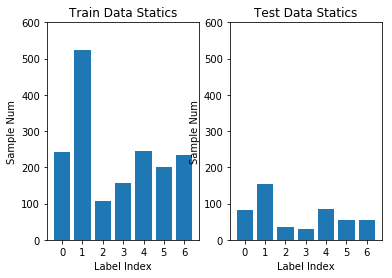

In [5]:
print("{}Train Data anf Test Data Info{}".format("*"*20, "*"*20))
print("==> Label list : "+("\n    {}"*7).format(*[(i,j) for j,i in label_dict.items()]))
inds, nums = np.unique(y[data.train_mask].numpy(), return_counts=True)
plt.figure(1)
plt.subplot(121)
plt.bar(x=inds, height=nums, width=0.8, bottom=0, align='center')
plt.xticks(ticks=range(7))
plt.xlabel(xlabel="Label Index")
plt.ylabel(ylabel="Sample Num")
plt.ylim((0, 600))
plt.title(label="Train Data Statics")
inds, nums = np.unique(y[data.test_mask].numpy(), return_counts=True)
plt.subplot(122)
plt.bar(x=inds, height=nums, width=0.8, bottom=0, align='center')
plt.xticks(ticks=range(7))
plt.xlabel(xlabel="Label Index")
plt.ylabel(ylabel="Sample Num")
plt.ylim((0, 600))
plt.title(label="Test Data Statics")

### PyG构建GCN

In [6]:
'''
使用官方教程上的例子，利用MessagePassing类来构建GCN层。
初始化阶段：
Input :
    in_channels : (int)输入的节点特征维度
    out_channels : (int)节点输出的特征维度
Output :
    None

forward阶段：
Input :
    x : (Tensor)输入的节点特征矩阵，shape(N, in_channels)
    edge_index : (LongTensor)输入的边矩阵，shape(2, E)
Output :
    out : (Tensor)输出层的节点logits，shape(N, num_class)
'''
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation.
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)  # (N, in_channels) -> (N, out_channels)

        # Step 3-5: Start propagating messages.
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

    def message(self, x_j, edge_index, size):
        # x_j has shape [E, out_channels]
        # edge_index has shape [2, E]

        # Step 3: Normalize node features.
        row, col = edge_index  # [E,], [E,]
        deg = degree(row, size[0], dtype=x_j.dtype)  # [N, ]
        deg_inv_sqrt = deg.pow(-0.5)   # [N, ]
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]  # [E, ]

        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]

        # Step 5: Return new node embeddings.
        return aggr_out

In [7]:
'''
构建模型，使用两层GCN，第一层GCN使得节点矩阵
        (N, in_channel) -> (N, 16)
第二层GCN使得节点矩阵
        (N, 16) -> (N, num_class)
激活函数使用relu函数，网络最后对节点的各类别score使用softmax归一化，
返回归一化后的Tensor。
'''
class Net(torch.nn.Module):
    def __init__(self, feat_dim, num_class):
        super(Net, self).__init__()
        self.conv1 = GCNConv(feat_dim, 16)
        self.conv2 = GCNConv(16, num_class)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [ ]:
'''
开始训练模型
'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(feat_dim=data.num_node_features, num_class=7).to(device)         # Initialize model
data = data.to(device)                                                       
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4) # Initialize optimizer and training params

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    # Get output
    out = model(data)
    
    # Get loss
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    _, pred = out.max(dim=1)
    
    # Get predictions and calculate training accuracy
    correct = float(torch.masked_select(pred, data.train_mask.byte()).eq(torch.masked_select(data.y, data.train_mask.byte())).sum().item())
    acc = correct / data.train_mask.sum().item()
    print('[Epoch {}/200] Loss {:.4f}, train acc {:.4f}'.format(epoch, loss.cpu().detach().data.item(), acc))
    
    # Backward
    loss.backward()
    optimizer.step()
    
    # Evaluation on test data every 10 epochs
    if (epoch+1) % 10 == 0:
        model.eval()
        _, pred = model(data).max(dim=1)
        correct = float(pred[data.test_mask.byte()].eq(data.y[data.test_mask.byte()]).sum().item())
        acc = correct / data.test_mask.sum().item()
        print('Accuracy: {:.4f}'.format(acc))